In [137]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

# Set the path to your image data directory
data_path = '/content/drive/My Drive/cv/cv_ass_3/a3_dataset/img'

# Initialize lists to store file paths, image names, labels, image heights, image widths, and image sizes
file_paths = []
image_names = []
labels = []
image_heights = []
image_widths = []
image_sizes = []

# Walk through the directory and collect file paths, image names, labels, and image attributes
for root, dirs, files in os.walk(data_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_paths.append(file_path)
        image_name_with_extension = file  # Extract image name with the file extension
        image_name_without_extension, _ = os.path.splitext(image_name_with_extension)
        image_names.append(image_name_without_extension)  # Extract image name without extension
        labels.append(os.path.basename(root))

        # Get image attributes using PIL
        with Image.open(file_path) as img:
            height, width = img.size
            size = os.path.getsize(file_path)
            image_heights.append(height)
            image_widths.append(width)
            image_sizes.append(size)

# Create a DataFrame
data = pd.DataFrame({
    'File_Path': file_paths,
    'Image_Name': image_names,
    'Label': labels,
    'Image_Height': image_heights,
    'Image_Width': image_widths,
    'Image_Size': image_sizes
})

# Split the data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Reset the index for each dataframe
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Print the number of samples in each set
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
print(f"Number of test samples: {len(test_data)}")


Number of training samples: 720
Number of validation samples: 80
Number of test samples: 200


In [139]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already defined and processed your data frames: train_data, val_data, and test_data

# Create empty lists to store data
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

import tensorflow as tf


import tensorflow as tf

# Function to load and convert an image with a target size and return it as a tensor
def load_and_convert_image(file_path, target_size=(64, 64)):
    # Load the image using Keras
    image = tf.keras.preprocessing.image.load_img(file_path, target_size=target_size)

    # Convert the loaded image to a NumPy array
    image = tf.keras.preprocessing.image.img_to_array(image)

    # Scale the pixel values to the [0, 1] range
    image /= 255.0

    # Convert the NumPy array to a TensorFlow tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    return image



# Loop through the training data frame
for i in range(len(train_data)):
    file_path = train_data.loc[i, 'File_Path']
    image = load_and_convert_image(file_path)
    X_train.append(image)
    y_train.append(train_data.loc[i, 'Label'])

# Loop through the validation data frame
for i in range(len(val_data)):
    file_path = val_data.loc[i, 'File_Path']
    image = load_and_convert_image(file_path)
    X_val.append(image)
    y_val.append(val_data.loc[i, 'Label'])

# Loop through the test data frame
for i in range(len(test_data)):
    file_path = test_data.loc[i, 'File_Path']
    image = load_and_convert_image(file_path)
    X_test.append(image)
    y_test.append(test_data.loc[i, 'Label'])



In [140]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

num_classes = 4
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_val_one_hot = tf.keras.utils.to_categorical(y_val_encoded, num_classes=num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)


In [141]:

X_train = np.array(X_train)
y_train = np.array(y_train_one_hot)
X_val = np.array(X_val)
y_val = np.array(y_val_one_hot)
X_test = np.array(X_test)
y_test = np.array(y_test_one_hot)


In [142]:
y_train

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [143]:
X_train[0].shape

(64, 64, 3)

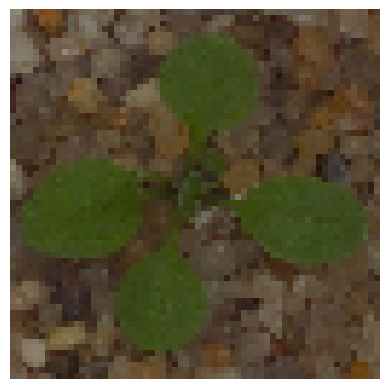

In [144]:
plt.imshow(X_train[0])
plt.axis('off')
plt.show()

In [145]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras import models

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
model = models.Sequential()
for layer in base_model.layers[:8]:
    layer.trainable = False
    model.add(layer)

In [146]:
# Set the layers beyond the first two blocks to be untrainable
from tensorflow.keras import layers


from keras.layers import Flatten, Dense, Dropout
from keras.models import Model

# Reduce spatial dimensions by using GlobalAveragePooling2D
model.add(layers.GlobalAveragePooling2D())

# Now, add 5 custom fully connected layers for classification
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))  # 4 classes for classification


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/32
23/23 [==============================] - 2s 53ms/step - loss: 1.6469 - accuracy: 0.2819 - val_loss: 1.3387 - val_accuracy: 0.4000
Epoch 2/32
23/23 [==============================] - 1s 44ms/step - loss: 1.2763 - accuracy: 0.4153 - val_loss: 1.1388 - val_accuracy: 0.5500
Epoch 3/32
23/23 [==============================] - 1s 44ms/step - loss: 1.1603 - accuracy: 0.4917 - val_loss: 0.9768 - val_accuracy: 0.6125
Epoch 4/32
23/23 [==============================] - 1s 44ms/step - loss: 1.0499 - accuracy: 0.5569 - val_loss: 1.2688 - val_accuracy: 0.4125
Epoch 5/32
23/23 [==============================] - 1s 44ms/step - loss: 0.9839 - accuracy: 0.5861 - val_loss: 0.9094 - val_accuracy: 0.6375
Epoch 6/32
23/23 [==============================] - 1s 45ms/step - loss: 0.9398 - accuracy: 0.6278 - val_loss: 0.8153 - val_accuracy: 0.7000
Epoch 7/32
23/23 [==============================] - 1s 45ms/step - loss: 0.7951 - accuracy: 0.6569 - val_loss: 0.7124 - val_accuracy: 0.7625
Epoch 8/32
23

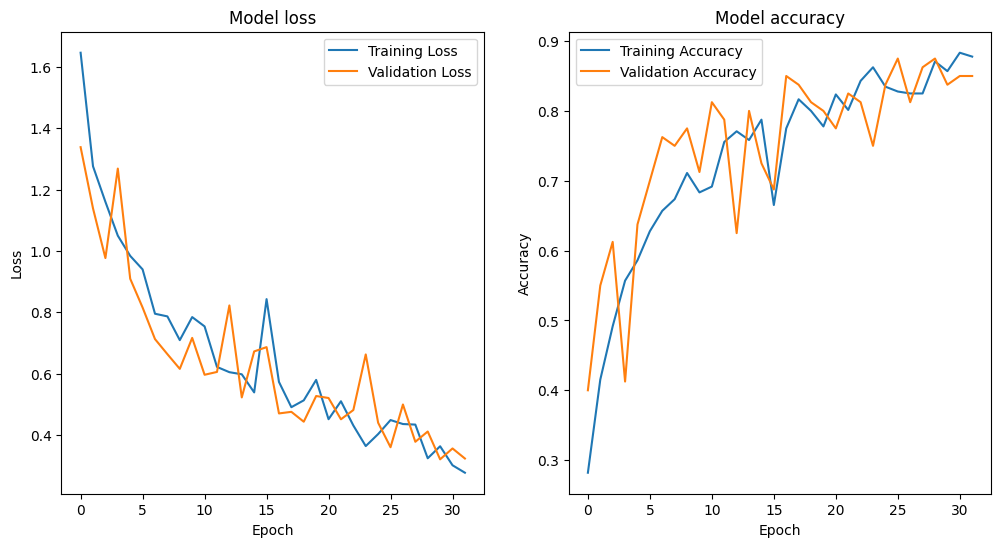

7/7 [==============================] - 0s 35ms/step - loss: 0.3993 - accuracy: 0.8400
Test loss: 0.39934098720550537
Test accuracy: 0.8399999737739563


In [147]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=32)
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_results = model.evaluate(X_test, y_test)
print("Test loss:", test_results[0])
print("Test accuracy:", test_results[1])


In [148]:
(X_train[0].shape)

(64, 64, 3)

In [149]:
import json
with open('/content/drive/My Drive/cv/cv_ass_3/a3_dataset/bbox.json', 'r') as json_file:
    bbox_data = json.load(json_file)

# Create lists to store image names, heights, and widths
train_image_names = []
train_normalized_heights = []
train_normalized_widths = []
val_image_names = []
val_normalized_heights = []
val_normalized_widths = []
test_image_names = []
test_normalized_heights = []
test_normalized_widths = []

# Normalize the bounding box dimensions for training data
for index, row in train_data.iterrows():
    image_name = row['Image_Name']
    label = row['Label']
    height = bbox_data[label][image_name]['height']
    width = bbox_data[label][image_name]['width']
    image_height = row['Image_Height']
    image_width = row['Image_Width']

    normalized_height = height / image_height
    normalized_width = width / image_width

    train_image_names.append(image_name)
    train_normalized_heights.append(normalized_height)
    train_normalized_widths.append(normalized_width)

# Normalize the bounding box dimensions for validation data
for index, row in val_data.iterrows():
    image_name = row['Image_Name']
    label = row['Label']
    height = bbox_data[label][image_name]['height']
    width = bbox_data[label][image_name]['width']
    image_height = row['Image_Height']
    image_width = row['Image_Width']

    normalized_height = height / image_height
    normalized_width = width / image_width

    val_image_names.append(image_name)
    val_normalized_heights.append(normalized_height)
    val_normalized_widths.append(normalized_width)

# Normalize the bounding box dimensions for test data
for index, row in test_data.iterrows():
    image_name = row['Image_Name']
    label = row['Label']
    height = bbox_data[label][image_name]['height']
    width = bbox_data[label][image_name]['width']
    image_height = row['Image_Height']
    image_width = row['Image_Width']

    normalized_height = height / image_height
    normalized_width = width / image_width

    test_image_names.append(image_name)
    test_normalized_heights.append(normalized_height)
    test_normalized_widths.append(normalized_width)


In [150]:
regression_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
model = models.Sequential()
for layer in base_model.layers[:8]:
    layer.trainable = False
    model.add(layer)

In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create a regression model
regression_model = Sequential()
regression_model.add(regression_base_model)  # Add your modified VGG16 base model
regression_model.add(Dense(64, activation='relu'))
regression_model.add(Dense(2, activation='sigmoid'))  # Two output nodes for height and width

# Compile the regression model
regression_model.compile(optimizer='adam', loss='mean_squared_error')


In [152]:
# Regression model
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# Create a new input layer for the regression task
input_layer = Input(shape=(64, 64, 3))

regression_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
model = models.Sequential()
for layer in base_model.layers[:8]:
    layer.trainable = False
    model.add(layer)
# Extract a specific layer from the base model
x_reg = regression_base_model.get_layer('block2_pool').output

# Add layers for regression
x_reg = Flatten()(x_reg)
x_reg = Dense(64, activation='relu')(x_reg)
x_reg = Dense(256)(x_reg)
x_reg = Dense(128)(x_reg)
output_layer = Dense(2)(x_reg)  # Output two float values in the range [0, 1]

# Create the regression model
regression_model = Model(inputs=regression_base_model.input, outputs=output_layer)

# Compile the regression model
regression_model.compile(loss='mean_squared_error', optimizer='adam')

# Print the summary of the regression model
regression_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [153]:

y_train_stack = np.column_stack((train_normalized_heights, train_normalized_widths))
y_val_stack = np.column_stack((val_normalized_heights, val_normalized_widths))
y_test_stack = np.column_stack((test_normalized_heights, test_normalized_widths))

In [154]:


history = regression_model.fit(x=X_train, y=y_train_stack,
                               validation_data=(X_val, y_val_stack),
                               epochs=10
                               )



Epoch 1/10
23/23 [==============================] - 7s 267ms/step - loss: 3429.6997 - val_loss: 0.0869
Epoch 2/10
23/23 [==============================] - 6s 267ms/step - loss: 0.0558 - val_loss: 0.0469
Epoch 3/10
23/23 [==============================] - 6s 263ms/step - loss: 0.0418 - val_loss: 0.0438
Epoch 4/10
23/23 [==============================] - 6s 264ms/step - loss: 0.0406 - val_loss: 0.0441
Epoch 5/10
23/23 [==============================] - 6s 266ms/step - loss: 0.0398 - val_loss: 0.0437
Epoch 6/10
23/23 [==============================] - 6s 265ms/step - loss: 0.0391 - val_loss: 0.0445
Epoch 7/10
23/23 [==============================] - 6s 264ms/step - loss: 0.0385 - val_loss: 0.0435
Epoch 8/10
23/23 [==============================] - 6s 266ms/step - loss: 0.0383 - val_loss: 0.0451
Epoch 9/10
23/23 [==============================] - 6s 260ms/step - loss: 0.0384 - val_loss: 0.0463
Epoch 10/10
23/23 [==============================] - 6s 270ms/step - loss: 0.0373 - val_loss: 0.0

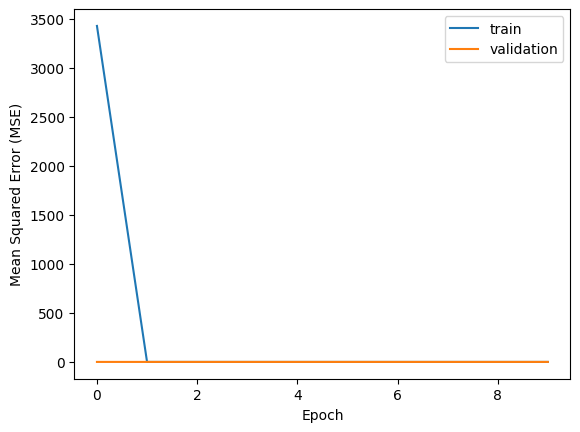

In [155]:
import matplotlib.pyplot as plt

# Plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()


In [156]:
from sklearn.metrics import mean_squared_error

# Make predictions for the test data
test_predictions = regression_model.predict(X_test)

# Calculate MSE for height and width predictions
test_mse_height = mean_squared_error(test_normalized_heights, test_predictions[:, 0])
test_mse_width = mean_squared_error(test_normalized_widths, test_predictions[:, 1])

print(f"Test MSE for height: {test_mse_height}")
print(f"Test MSE for width: {test_mse_width}")


7/7 [==============================] - 0s 31ms/step
Test MSE for height: 0.04326222686130878
Test MSE for width: 0.03984233036920166


Q4 improve the model: classification

In [157]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Create a VGG16 base model with pre-trained weights (excluding top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64
, 64, 3))

# Freeze the first two blocks of VGG16
for layer in base_model.layers[:10]:  # Adjust the number of layers to freeze as needed
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the VGG16 base model
model.add(base_model)

# Add a Flatten layer
model.add(Flatten())

# Fully connected layers with Batch Normalization and Dropout
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Adjust the dropout rate as needed

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Adjust the dropout rate as needed

# Output layer
model.add(Dense(2, activation='sigmoid'))  # Assuming 2 outputs for height and width, use 'sigmoid' activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])  # Use 'mse' for mean squared error

# Print model summary for architecture verification
model.summary()




Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_13 (Flatten)        (None, 2048)              0         
                                                                 
 dense_78 (Dense)            (None, 128)               262272    
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_79 (Dense)            (None, 64)                8256      
                                                     

In [158]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models

# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Create a Sequential model for refining
refined_model = models.Sequential()

# Add the VGG16 base model layers (with the first two blocks frozen)
for layer in base_model.layers[:8]:
    layer.trainable = False
    refined_model.add(layer)

# Add a Global Average Pooling layer to reduce spatial dimensions
refined_model.add(GlobalAveragePooling2D())

# Add Batch Normalization and Dropout layers
refined_model.add(BatchNormalization())
refined_model.add(Dropout(0.5))  # Adjust the dropout rate as needed

# Add fully connected layers
refined_model.add(Dense(256, activation='relu'))
refined_model.add(Dense(128, activation='relu'))
refined_model.add(Dense(64, activation='relu'))
refined_model.add(Dense(32, activation='relu'))

# Output layer with 4 classes for classification
refined_model.add(Dense(4, activation='softmax'))

# Compile the model
refined_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary for architecture verification
refined_model.summary()


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)     

In [159]:
y_train

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [161]:
history = refined_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=32)

Epoch 1/32
23/23 [==============================] - 3s 55ms/step - loss: 1.2186 - accuracy: 0.4667 - val_loss: 1.9586 - val_accuracy: 0.3625
Epoch 2/32
23/23 [==============================] - 1s 44ms/step - loss: 0.8624 - accuracy: 0.6278 - val_loss: 2.6229 - val_accuracy: 0.3375
Epoch 3/32
23/23 [==============================] - 1s 44ms/step - loss: 0.6904 - accuracy: 0.7417 - val_loss: 2.9834 - val_accuracy: 0.3375
Epoch 4/32
23/23 [==============================] - 1s 45ms/step - loss: 0.6641 - accuracy: 0.7403 - val_loss: 1.9475 - val_accuracy: 0.3750
Epoch 5/32
23/23 [==============================] - 1s 45ms/step - loss: 0.5610 - accuracy: 0.7778 - val_loss: 0.9679 - val_accuracy: 0.5000
Epoch 6/32
23/23 [==============================] - 1s 45ms/step - loss: 0.5457 - accuracy: 0.7875 - val_loss: 1.1676 - val_accuracy: 0.5375
Epoch 7/32
23/23 [==============================] - 1s 45ms/step - loss: 0.5184 - accuracy: 0.7931 - val_loss: 0.5283 - val_accuracy: 0.7875
Epoch 8/32
23

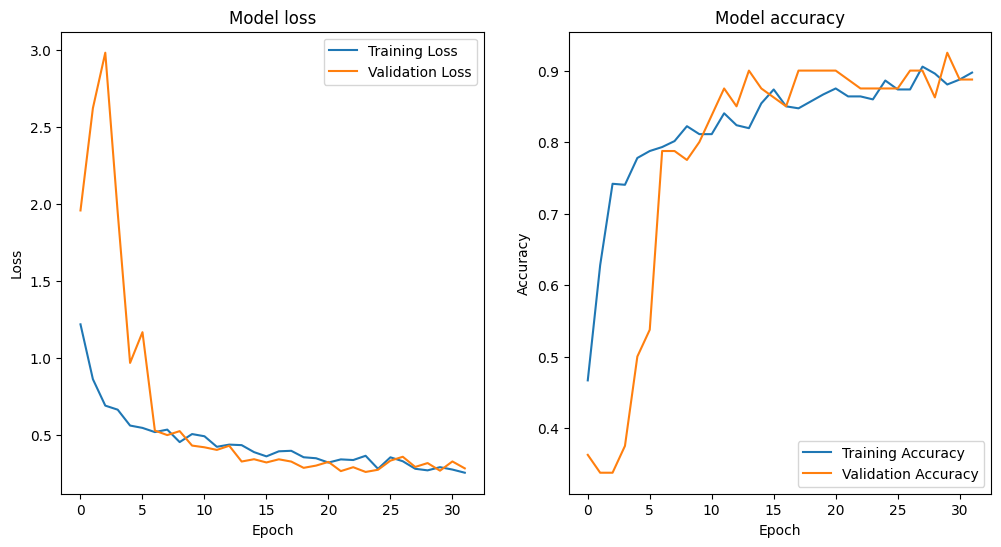

7/7 [==============================] - 0s 37ms/step - loss: 0.3306 - accuracy: 0.8650
Test loss: 0.3305932879447937
Test accuracy: 0.8650000095367432


In [177]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_results = refined_model.evaluate(X_test, y_test)
print("Test loss:", test_results[0])
print("Test accuracy:", test_results[1])

In [174]:
test_results_refined = refined_model.evaluate(X_test, y_test)


7/7 [==============================] - 0s 37ms/step - loss: 0.3306 - accuracy: 0.8650


In [175]:
test_results_refined

[0.3305932879447937, 0.8650000095367432]

Q5 discuss the results:

in classification
training a model requires enough data
augmantaion would help as we can change the orintation for example in each epoch
this can help us benefit from more epochs
because i realised that 32 epochs is more than enough and the training is not improved after it

the regularization improved my accuracy from 84% to 86.5%

i think it helped and actually the validation accuraccy was nearly the same